### Importing necessary libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#Date time
import datetime as dt
from datetime import timedelta, date

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import geopandas

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report,confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch


# Planetary Computer Tools
import pystac
import pystac_client
import stackstac
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
import contextily
pc.settings.set_subscription_key('b0067a12405d4fd4a4cc82d28869d9bc')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

#Scaling using Dask
import dask_gateway
import dask
import xarray as xr
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd

In [39]:
crop_presence_data = pd.read_csv("./Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


### Creating bounding boxes from the given coordinate

In [40]:
def calculate_bbox(lat_long, box_size_deg=0.0004):
    lat_long=lat_long.replace('(','').replace(')','').replace(' ','').split(',')
    
    min_lon = float(lat_long[1]) - box_size_deg/2
    min_lat = float(lat_long[0])- box_size_deg/2
    max_lon = float(lat_long[1]) + box_size_deg/2
    max_lat = float(lat_long[0]) + box_size_deg/2
    
    return min_lon, min_lat, max_lon, max_lat

#### Defining variables 

In [41]:
time_of_interest = '2022-12-01/2022-12-31'
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [42]:
rvi_df = pd.DataFrame() 
bbox = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    bbox.append(calculate_bbox(coordinates))

bbox_data = pd.DataFrame(bbox,columns =['min_lon', 'min_lat', 'max_lon', 'max_lat'])

100%|████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<?, ?it/s]


#### Dask

### New approach

In [43]:
bbox_data

,min_lon,min_lat,max_lon,max_lat
0,105.251435,10.323527,105.251835,10.323927
1,105.278234,10.322164,105.278634,10.322564
2,105.252343,10.321256,105.252743,10.321656
3,105.250980,10.323981,105.251380,10.324381
4,105.273692,10.324436,105.274092,10.324836
...,...,...,...,...
595,105.673413,10.013743,105.673813,10.014143
596,105.673413,10.013289,105.673813,10.013689
597,105.673413,10.012835,105.673813,10.013235
598,105.673413,10.012380,105.673813,10.012780


In [44]:
def create_rvi_for_each_aoi(time_of_interest, bbox):
    #Creating catalog
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
    items = search.get_all_items()
    # Load the data using Open Data Cube
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, chunks={"time":10, "x": 307200, "y": 307200},
                     crs="EPSG:4326", resolution=scale)
    print('------------')
    #print(data)
    mean_aoi = data.mean(dim=['latitude','longitude'])
    
    data['vh'] = mean_aoi["vh"]
    data['vv'] = mean_aoi["vv"]

    dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
    m = 1 - dop
    data['rvi'] = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))
    return data

In [45]:
bbox_data.shape

(600, 4)

#### Creating Data

In [69]:
for i in range(600):
    vh=[]
    vv=[]
    rvi=[]
    ds = create_rvi_for_each_aoi(time_of_interest,bbox_data.iloc[i])
    
    vh= ds.vh.compute().to_series()
    vv= ds.vv.compute().to_series()
    rvi= ds.rvi.compute().to_series()
    ground_truth_location= crop_presence_data.iloc[i]['Latitude and Longitude']
    ground_truth_landclass= crop_presence_data.iloc[i]['Class of Land']
    ground_truth = {'Location': ground_truth_location , 'Class_of_Land': ground_truth_landclass}
    ground_truth_data = pd.DataFrame(data=ground_truth, index= [i])    
    frame = { 'VV': vv, 'VH': vh, 'RVI': rvi, 'Location': crop_presence_data.iloc[i]['Latitude and Longitude'], 'Class_of_Land': ground_truth_landclass}
    vh_vv_rvi_data = pd.DataFrame(frame)
    vh_vv_rvi_data.to_csv('rvi-test.csv', mode='a', index=True, header=False)

------------
------------


In [13]:
vh_vv_rvi_data

NameError: name 'vh_vv_rvi_data' is not defined

In [41]:
def create_latlong_csv(lat_long, items):
    frame = { 'latitude_longitude': lat_long}
    lat_long_data = pd.DataFrame(frame)
    for i in range(items):
         lat_long_data.to_csv('rvi.csv', mode='a', index=False, header=False)

In [44]:
df1 = df1['id'].to_frame()
print(df1)
for i in range(250):
    create_latlong_csv(df1.iloc[i], 2)

                                           id
0     (10.18019073690894, 105.32022315786804)
1    (10.561107033461816, 105.12772097986661)
2    (10.623790611954897, 105.13771401411867)
3    (10.583364246115156, 105.23946127195805)
4     (10.20744446668854, 105.26844107128906)
..                                        ...
245  (10.308283266873062, 105.50872812216863)
246  (10.582910017285496, 105.23991550078767)
247  (10.581547330796518, 105.23991550078767)
248  (10.629241357910818, 105.15315779432643)
249  (10.574733898351617, 105.10410108072531)

[250 rows x 1 columns]


In [25]:
df1 = crop_presence_data['Class of Land'].to_frame()
print(df1)
for i in range(600):
    create_latlong_csv(df1.iloc[i], 9)

    Class of Land
0            Rice
1            Rice
2            Rice
3            Rice
4            Rice
..            ...
595      Non Rice
596      Non Rice
597      Non Rice
598      Non Rice
599      Non Rice

[600 rows x 1 columns]


#### Merging multiple csv files and creating a single file

In [3]:
import os
import glob
import pandas as pd
# merging the files
joined_files = os.path.join("./Data/Temp/", "rvi-*.csv")
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)

In [4]:
final_rice_df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

In [5]:
final_rice_df.shape

(36600, 6)

In [6]:
final_rice_df.head()

,image_taken,VV,VH,RVI,location,Class_of_Land
0,10/03/2022,0.089866,0.032007,0.902072,"(10.323727047081501, 105.2516346045924)",Rice
1,11/03/2022,0.050158,0.029283,1.171599,"(10.323727047081501, 105.2516346045924)",Rice
2,22/03/2022,0.222246,0.070375,0.838371,"(10.323727047081501, 105.2516346045924)",Rice
3,23/03/2022,0.098687,0.037883,0.943192,"(10.323727047081501, 105.2516346045924)",Rice
4,10/03/2022,0.315821,0.049165,0.501215,"(10.322364360592521, 105.27843410554115)",Rice


In [7]:
final_rice_df.apply(lambda x: sum(x.isnull()), axis = 0)

image_taken      0
VV               0
VH               0
RVI              0
location         0
Class_of_Land    0
dtype: int64

In [8]:
final_rice_df.dropna()

,image_taken,VV,VH,RVI,location,Class_of_Land
0,10/03/2022,0.089866,0.032007,0.902072,"(10.323727047081501, 105.2516346045924)",Rice
1,11/03/2022,0.050158,0.029283,1.171599,"(10.323727047081501, 105.2516346045924)",Rice
2,22/03/2022,0.222246,0.070375,0.838371,"(10.323727047081501, 105.2516346045924)",Rice
3,23/03/2022,0.098687,0.037883,0.943192,"(10.323727047081501, 105.2516346045924)",Rice
4,10/03/2022,0.315821,0.049165,0.501215,"(10.322364360592521, 105.27843410554115)",Rice
...,...,...,...,...,...,...
36595,06/09/2022,0.437144,0.059023,0.446633,"(10.012126069934741, 105.67361318732796)",Non Rice
36596,07/09/2022,0.129796,0.067208,1.107641,"(10.012126069934741, 105.67361318732796)",Non Rice
36597,18/09/2022,0.250619,0.081351,0.851692,"(10.012126069934741, 105.67361318732796)",Non Rice
36598,19/09/2022,0.283836,0.077845,0.762670,"(10.012126069934741, 105.67361318732796)",Non Rice


**Adding Month variable**

In [9]:
final_rice_df['month'] = pd.to_datetime(final_rice_df['image_taken'])

In [10]:
final_rice_df['month'] = final_rice_df['month'].dt.month

In [11]:
final_rice_df['month']

0        10
1        11
2         3
3         3
4        10
         ..
36595     6
36596     7
36597     9
36598     9
36599     9
Name: month, Length: 36600, dtype: int64

**Adding mean VRAT(VH/VV)**

In [12]:
final_rice_df['VRAT'] = final_rice_df['VH'] / final_rice_df['VV']

In [13]:
final_rice_df['span']= final_rice_df['VH'] + final_rice_df['VV']

In [14]:
final_rice_df['diff']= final_rice_df['VV'] - final_rice_df['VH']

In [15]:
from datetime import datetime
date_format = "%d/%m/%Y"

b = datetime.strptime('01/12/2021', date_format)

final_rice_df['Day_of_Year'] = pd.to_datetime(final_rice_df['image_taken'], format =date_format) - b

In [16]:
final_rice_df['Day_of_Year'] = final_rice_df['Day_of_Year'].dt.days


In [17]:
final_rice_df['Day_of_Year']

0         99
1        100
2        111
3        112
4         99
        ... 
36595    279
36596    280
36597    291
36598    292
36599    303
Name: Day_of_Year, Length: 36600, dtype: int64

**Exploratory Data Analysis**

In [18]:
final_rice_df.describe()

,VV,VH,RVI,month,VRAT,span,diff,Day_of_Year
count,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000
mean,0.157005,0.034366,0.724666,6.688525,0.279109,0.191372,0.122639,177.590164
std,0.147482,0.025968,0.257823,3.541563,0.147148,0.164622,0.133231,111.068825
min,0.003976,0.001901,0.016705,1.000000,0.004203,0.007550,-0.008665,3.000000
25%,0.044888,0.007984,0.567359,4.000000,0.182356,0.060123,0.027173,76.000000
50%,0.134730,0.030811,0.730420,6.000000,0.257498,0.169574,0.098960,172.000000
75%,0.243003,0.053042,0.897571,10.000000,0.353241,0.297476,0.188743,279.000000
max,12.621059,0.257068,1.500241,12.000000,1.358389,12.674100,12.568018,364.000000


In [18]:
final_rice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36600 entries, 0 to 36599
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_taken    36600 non-null  object 
 1   VV             36600 non-null  float64
 2   VH             36600 non-null  float64
 3   RVI            36600 non-null  float64
 4   location       36600 non-null  object 
 5   Class_of_Land  36600 non-null  object 
 6   month          36600 non-null  int64  
 7   VRAT           36600 non-null  float64
 8   span           36600 non-null  float64
 9   diff           36600 non-null  float64
 10  Day_of_Year    36600 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 3.1+ MB


In [19]:
final_rice_df.VV.describe()

count    36600.000000
mean         0.157005
std          0.147482
min          0.003976
25%          0.044888
50%          0.134730
75%          0.243003
max         12.621059
Name: VV, dtype: float64

In [20]:
final_rice_df

,image_taken,VV,VH,RVI,location,Class_of_Land,month,VRAT,span,diff,Day_of_Year
0,10/03/2022,0.089866,0.032007,0.902072,"(10.323727047081501, 105.2516346045924)",Rice,10,0.356164,0.121872,0.057859,99
1,11/03/2022,0.050158,0.029283,1.171599,"(10.323727047081501, 105.2516346045924)",Rice,11,0.583817,0.079441,0.020875,100
2,22/03/2022,0.222246,0.070375,0.838371,"(10.323727047081501, 105.2516346045924)",Rice,3,0.316652,0.292621,0.151871,111
3,23/03/2022,0.098687,0.037883,0.943192,"(10.323727047081501, 105.2516346045924)",Rice,3,0.383868,0.136570,0.060804,112
4,10/03/2022,0.315821,0.049165,0.501215,"(10.322364360592521, 105.27843410554115)",Rice,10,0.155674,0.364987,0.266656,99
...,...,...,...,...,...,...,...,...,...,...,...
36595,06/09/2022,0.437144,0.059023,0.446633,"(10.012126069934741, 105.67361318732796)",Non Rice,6,0.135019,0.496166,0.378121,279
36596,07/09/2022,0.129796,0.067208,1.107641,"(10.012126069934741, 105.67361318732796)",Non Rice,7,0.517797,0.197003,0.062588,280
36597,18/09/2022,0.250619,0.081351,0.851692,"(10.012126069934741, 105.67361318732796)",Non Rice,9,0.324601,0.331970,0.169267,291
36598,19/09/2022,0.283836,0.077845,0.762670,"(10.012126069934741, 105.67361318732796)",Non Rice,9,0.274261,0.361681,0.205990,292


<AxesSubplot: title={'center': 'VV'}, xlabel='Class_of_Land'>

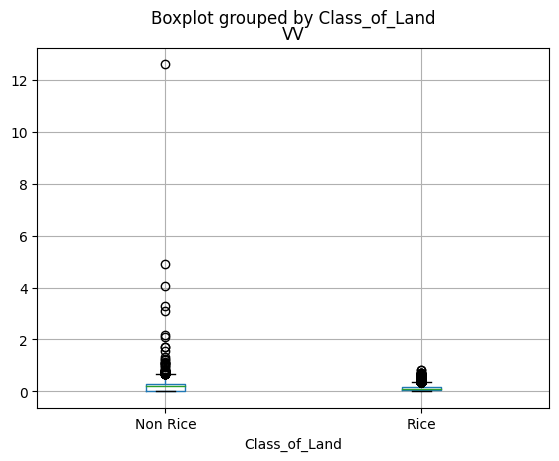

In [19]:
final_rice_df.boxplot(column='VV', by="Class_of_Land")

<AxesSubplot: xlabel='month', ylabel='VV'>

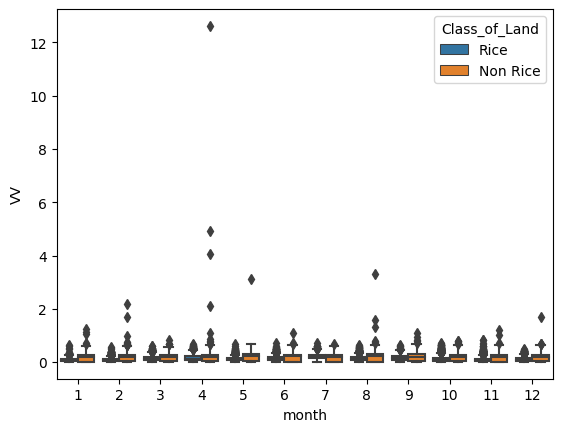

In [20]:
sns.boxplot(data=final_rice_df, x="month", y="VV", hue='Class_of_Land')

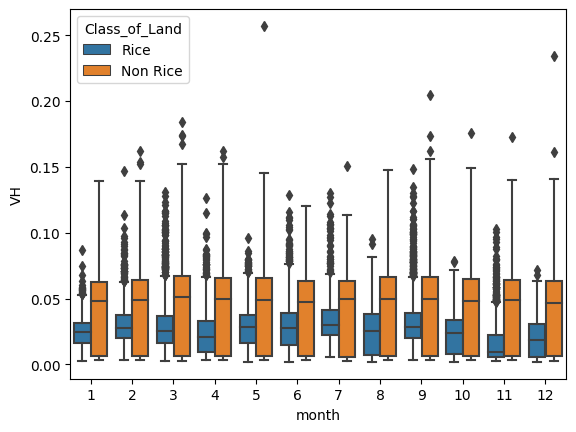

In [21]:
sns.boxplot(data=final_rice_df, x="month", y="VH", hue='Class_of_Land')
plt.savefig('MeanVH.png')

In [39]:
df_only_rice = final_rice_df[final_rice_df['Class_of_Land'] == 'Rice']
df_only_nonrice = final_rice_df[final_rice_df['Class_of_Land'] == 'Non Rice']

print(df_only_rice.describe())
print('--------------------')
print(df_only_nonrice.describe())

#sns.distplot(df_only_rice['VH'], kde=False, bins=10)
#sns.distplot(df_only_nonrice['VH'], kde=False, bins=10)



                 VV            VH           RVI         month          VRAT  \
count  18300.000000  18300.000000  18300.000000  18300.000000  18300.000000   
mean       0.128685      0.025846      0.692790      6.688525      0.270447   
std        0.102296      0.017466      0.304130      3.541612      0.165683   
min        0.003976      0.001901      0.052826      1.000000      0.013474   
25%        0.056962      0.010962      0.455923      4.000000      0.138454   
50%        0.099472      0.024813      0.721801      6.000000      0.253137   
75%        0.171024      0.034995      0.926022     10.000000      0.372071   
max        0.840178      0.148200      1.500241     12.000000      1.358389   

               span          diff   Day_of_Year  
count  18300.000000  18300.000000  18300.000000  
mean       0.154532      0.102839    177.590164  
std        0.109579      0.097629    111.070342  
min        0.007550     -0.008665      3.000000  
25%        0.077326      0.035059     

In [22]:
#5-River, 6-OtherFields, 7-Residence
AOI1 = final_rice_df.loc[final_rice_df['location']=='(10.323727047081501, 105.2516346045924)']
AOI2 = final_rice_df.loc[final_rice_df['location']=='(10.322364360592521, 105.27843410554115)']
AOI3 = final_rice_df.loc[final_rice_df['location']=='(10.012126069934741, 105.67361318732796)']
AOI4 = final_rice_df.loc[final_rice_df['location']=='(10.009400696956781, 105.67225050083903)']
AOI5 = final_rice_df.loc[final_rice_df['location']=='(10.321455902933202, 105.49555548610908)']
AOI6 = final_rice_df.loc[final_rice_df['location']=='(10.481616988271316, 104.91150805695796)']
AOI7 = final_rice_df.loc[final_rice_df['location']=='(10.007583781638141, 105.67270472966868)']

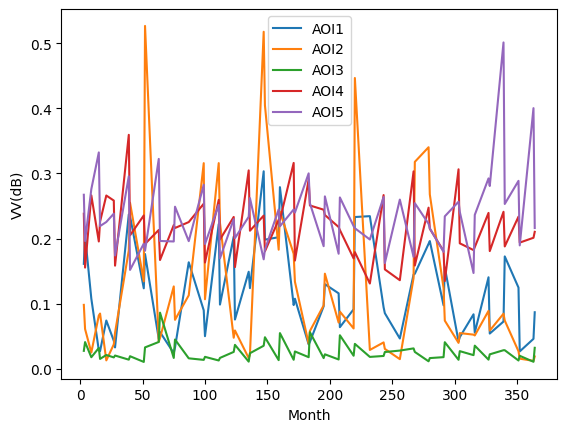

In [27]:
sns.lineplot(x = "Day_of_Year", y = "VV", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VV", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VV", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VV", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VV", data=AOI4, legend='auto', style=None, ci=None)

plt.xlabel('Month')
plt.ylabel('VV(dB)')

plt.legend(labels = ['AOI1', 'AOI2', 'AOI3', 'AOI4', 'AOI5'])

plt.savefig('vv.png')
plt.show()

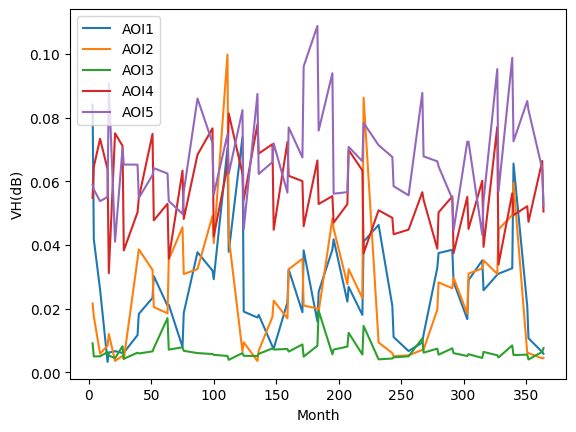

In [28]:
sns.lineplot(x = "Day_of_Year", y = "VH", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VH", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VH", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VH", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "Day_of_Year", y = "VH", data=AOI4, legend='auto', style=None, ci=None)
ylabel = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']
plt.xlabel('Month')
plt.ylabel('VH(dB)')
plt.legend(labels = ['AOI1', 'AOI2', 'AOI3', 'AOI4', 'AOI5'])
plt.savefig('vh.png')
plt.show()


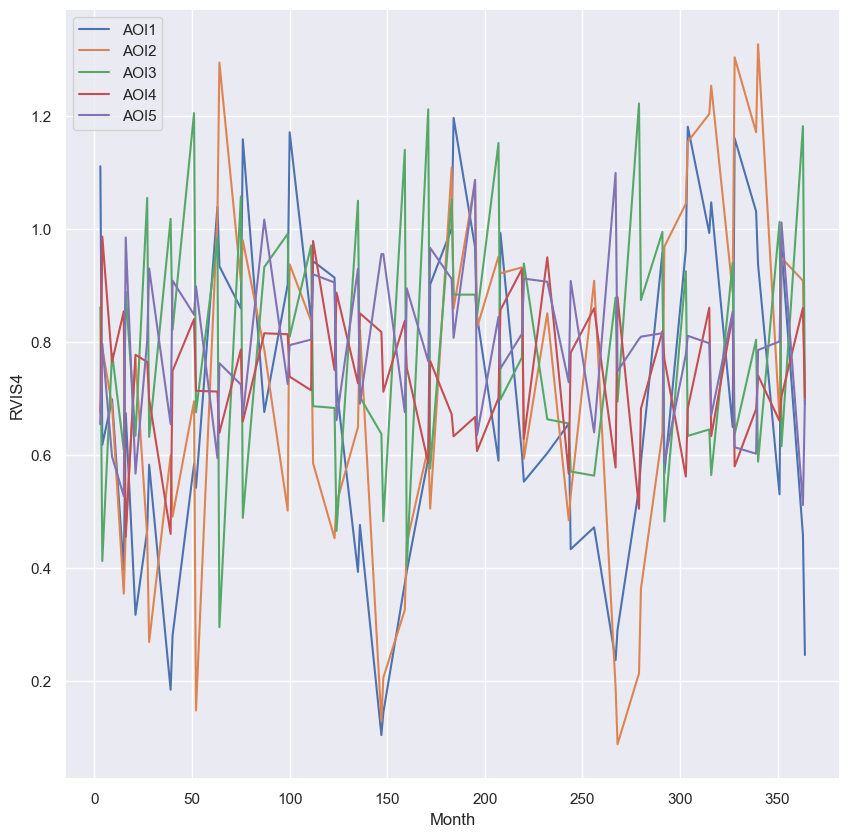

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x = "Day_of_Year", y = "RVI", data=AOI1, legend='auto', style=None, ci=None, ax=ax)
sns.lineplot(x = "Day_of_Year", y = "RVI", data=AOI2, legend='auto', style=None, ci=None, ax=ax)
sns.lineplot(x = "Day_of_Year", y = "RVI", data=AOI5, legend='auto', style=None, ci=None, ax=ax)
sns.lineplot(x = "Day_of_Year", y = "RVI", data=AOI6, legend='auto', style=None, ci=None, ax=ax)
sns.lineplot(x = "Day_of_Year", y = "RVI", data=AOI4, legend='auto', style=None, ci=None, ax=ax)

plt.xlabel('Month')
plt.ylabel('RVIS4')
plt.legend(labels = ['AOI1', 'AOI2', 'AOI3', 'AOI4', 'AOI5'])
plt.savefig('rvi.png')
plt.show()


In [38]:
import folium


m = folium.Map(location=[10.323727047081501, 105.2516346045924])

folium.Marker(
    location=[10.323727047081501, 105.2516346045924],
    popup="AOI1",
    icon=folium.Icon(icon="rice", color="blue"),
).add_to(m)

folium.Marker(
    location=[10.322364360592521, 105.27843410554115],
    popup="AOI2",
    icon=folium.Icon(icon= "rice", color="orange"),
).add_to(m)

folium.Marker(
    location=[10.321455902933202, 105.49555548610908],
    popup="AOI3",
    icon=folium.Icon(color="green", icon="river"),
).add_to(m)


folium.Marker(
    location=[10.007583781638141, 105.67270472966868],
    popup="AOI4",
    icon=folium.Icon(color="red", icon="building"),
).add_to(m)

folium.Marker(
    location=[10.481616988271316, 104.91150805695796],
    popup="AOI5",
    icon=folium.Icon(color="purple", icon="building"),
).add_to(m)
m

### Correlation

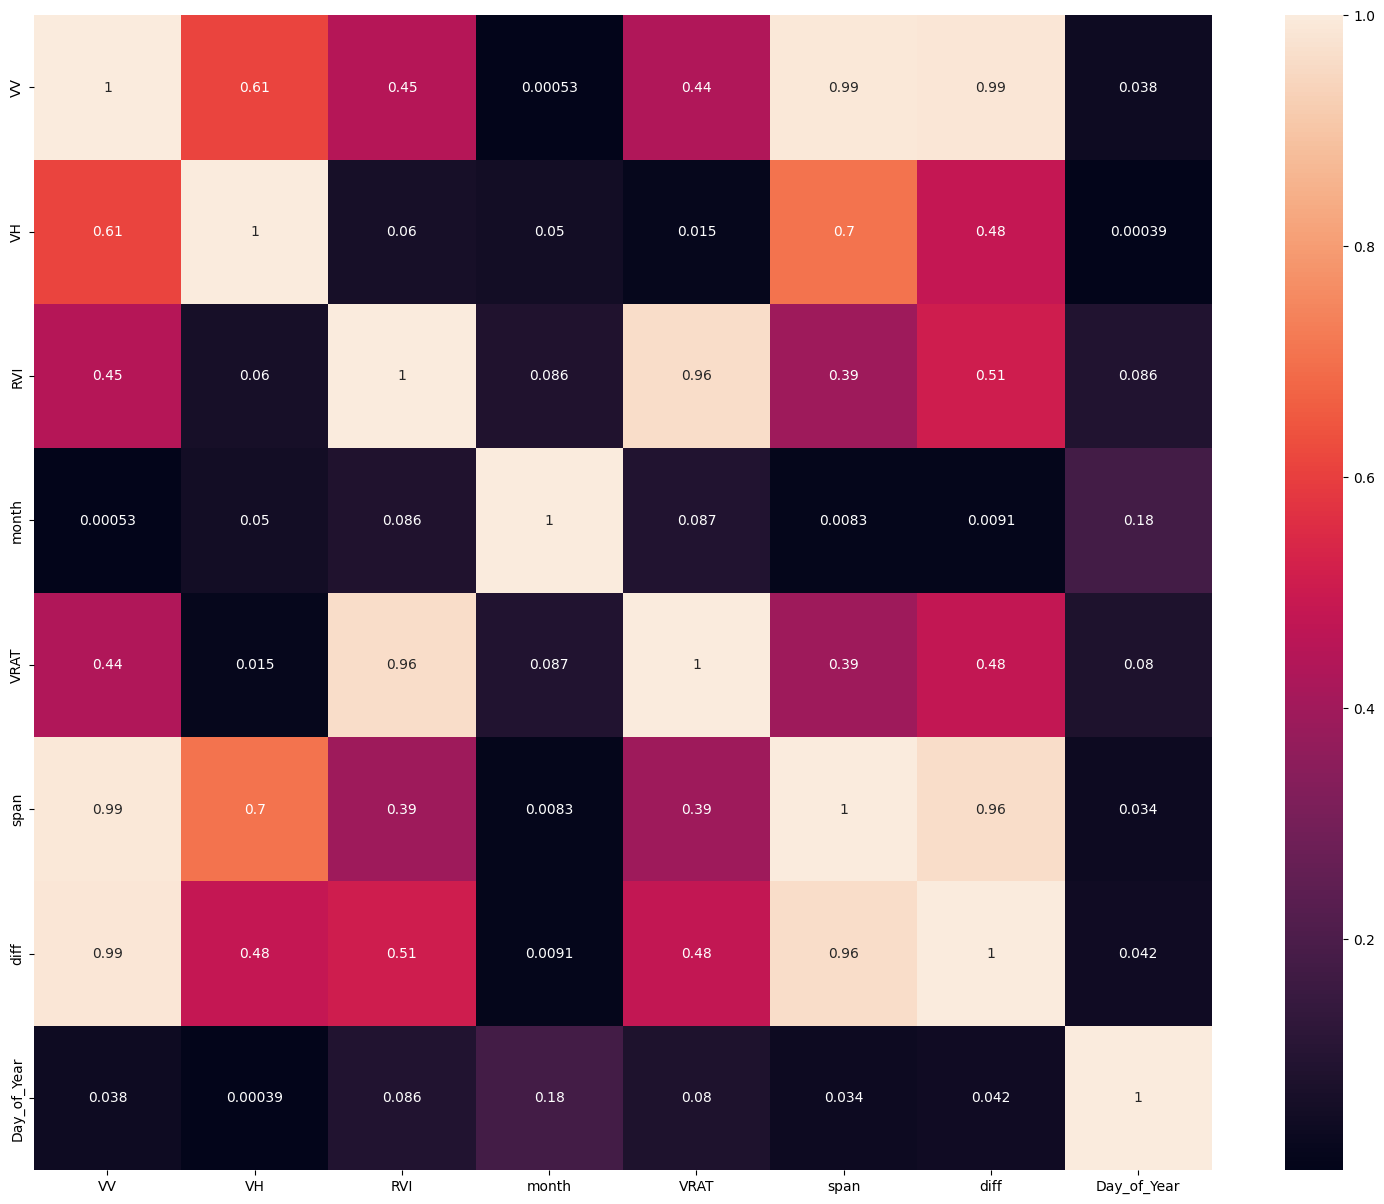

In [22]:
correlation_matrix = final_rice_df.corr().abs()
plt.figure(figsize=(19,15))
sns.heatmap(data=correlation_matrix,annot=True)
plt.savefig('correlation_heatmap.jpeg', dpi=100)
plt.show()

In [23]:
y_cat = LabelEncoder().fit(final_rice_df['Class_of_Land'])
final_rice_df['Class_of_Land'] = y_cat.transform(final_rice_df['Class_of_Land'])

In [52]:
final_rice_df

,image_taken,VV,VH,RVI,location,Class_of_Land,month,VRAT,span,diff
0,10/03/2022,0.089866,0.032007,0.902072,"(10.323727047081501, 105.2516346045924)",1,10,0.356164,0.121872,0.057859
1,11/03/2022,0.050158,0.029283,1.171599,"(10.323727047081501, 105.2516346045924)",1,11,0.583817,0.079441,0.020875
2,22/03/2022,0.222246,0.070375,0.838371,"(10.323727047081501, 105.2516346045924)",1,3,0.316652,0.292621,0.151871
3,23/03/2022,0.098687,0.037883,0.943192,"(10.323727047081501, 105.2516346045924)",1,3,0.383868,0.136570,0.060804
4,10/03/2022,0.315821,0.049165,0.501215,"(10.322364360592521, 105.27843410554115)",1,10,0.155674,0.364987,0.266656
...,...,...,...,...,...,...,...,...,...,...
36595,06/09/2022,0.437144,0.059023,0.446633,"(10.012126069934741, 105.67361318732796)",0,6,0.135019,0.496166,0.378121
36596,07/09/2022,0.129796,0.067208,1.107641,"(10.012126069934741, 105.67361318732796)",0,7,0.517797,0.197003,0.062588
36597,18/09/2022,0.250619,0.081351,0.851692,"(10.012126069934741, 105.67361318732796)",0,9,0.324601,0.331970,0.169267
36598,19/09/2022,0.283836,0.077845,0.762670,"(10.012126069934741, 105.67361318732796)",0,9,0.274261,0.361681,0.205990


In [24]:
X_reg = final_rice_df.drop(['image_taken','location', 'Class_of_Land'], axis=1)
y_reg= final_rice_df['Class_of_Land']

In [25]:
X_reg= StandardScaler().fit_transform(X_reg)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.30, random_state=8)

In [27]:
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)


X train shape:  (25620, 8)
X test shape:  (10980, 8)
Y train shape:  (25620,)
Y test shape:  (10980,)


#### Creating Tabnet classifier model

In [28]:
unsupervised_model = TabNetPretrainer(
optimizer_fn=torch.optim.Adam,
optimizer_params=dict(lr=2e-2),
mask_type="entmax"
)

In [31]:
classifier = TabNetClassifier(optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10,"gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax', verbose=0,seed=42)

classifier.fit(X_train=X_train, y_train=y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               max_epochs=100,
               batch_size=512, virtual_batch_size=512,
               eval_metric=['auc', 'balanced_accuracy'])


Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_1_balanced_accuracy = 0.84694


In [32]:
preds = classifier.predict(X_test)

Feature: 0, Score: 0.33735
Feature: 1, Score: 0.26928
Feature: 2, Score: 0.00402
Feature: 3, Score: 0.10023
Feature: 4, Score: 0.01344
Feature: 5, Score: 0.07013
Feature: 6, Score: 0.15729
Feature: 7, Score: 0.04826


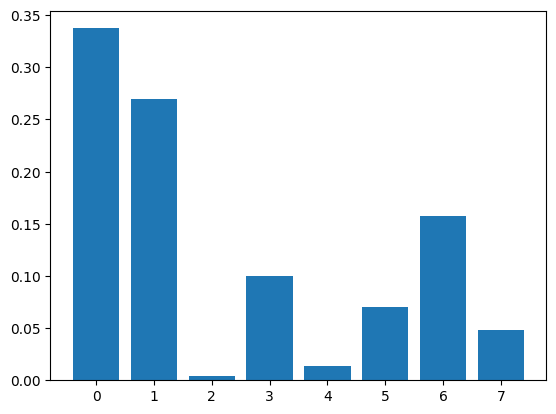

In [33]:
importance = classifier.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# Barchat for feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [34]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(preds,y_test)))
print("Precision:",precision_score(preds, y_test))
print('Recall: %.3f' % recall_score(preds, y_test))
print('F1 Score: %.3f' % f1_score(preds, y_test))
print(classification_report(preds,y_test))

Accuracy 84.70%
Precision: 0.8258170531312763
Recall: 0.862
F1 Score: 0.843
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5731
           1       0.83      0.86      0.84      5249

    accuracy                           0.85     10980
   macro avg       0.85      0.85      0.85     10980
weighted avg       0.85      0.85      0.85     10980



In [76]:
classifier.history

{'loss': [0.44815629720687866, 0.3788601106405258, 0.3685890471935272, 0.35837758660316466, 0.3498184818029404, 0.34521520853042603, 0.3433863294124603, 0.34494533240795133, 0.34340223670005793, 0.34382059395313264, 0.3406367605924606, 0.3406799107789993, 0.34094982445240013, 0.3391143387556076, 0.34072617709636704, 0.34127236783504494, 0.3417615962028503, 0.3402408432960511, 0.34073303282260897, 0.33817614436149596, 0.337572798728943, 0.33806594669818874, 0.34011085569858535, 0.3399884361028671, 0.3380900114774705, 0.33942535817623143], 'lr': [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.018000000000000002, 0.016200000000000003, 0.016200000000000003, 0.016200000000000003, 0.016200000000000003, 0.016200000000000003, 0.016200000000000003], 'val_0_auc': [0.8531553838467817, 0.

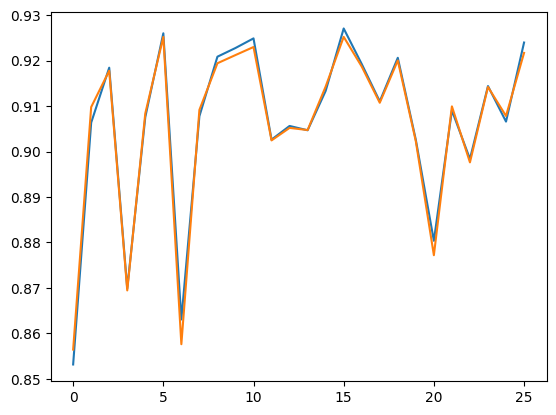

In [81]:
plt.plot(classifier.history['val_0_auc'])
plt.plot(classifier.history['val_1_auc'])

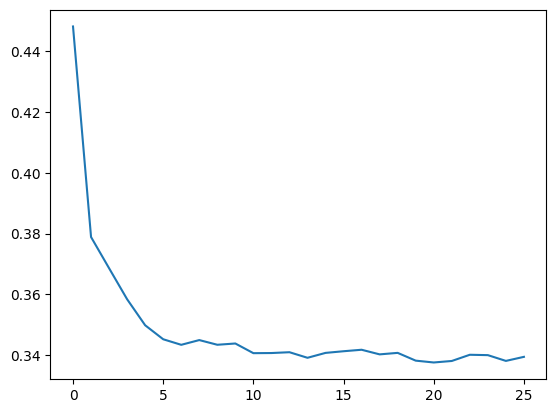

In [82]:
plt.plot(classifier.history['loss'])

In [36]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

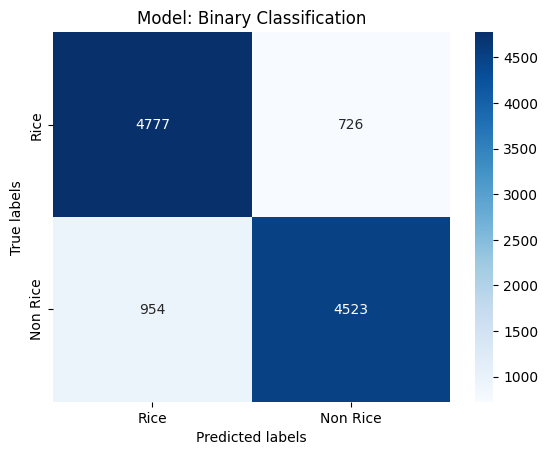

In [37]:
plot_confusion_matrix(y_test, preds,"Model: Binary Classification",['Rice', 'Non Rice'])

### Creating Ensemble learning with cross validation and bagging

In [187]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [188]:
scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=5)

In [189]:
scores.mean()

0.8066939890710383

In [190]:
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, oob_score=True, random_state=0)
score= cross_val_score(bagging_model, X_train, y_train, cv=5)
score.mean()

0.8593806921675773

In [191]:
from sklearn.ensemble import RandomForestClassifier
score= cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
score.mean()

0.8535063752276868

In [192]:
dt_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf= 0.16, random_state= 1)
bagging_model = BaggingClassifier(base_estimator= dt_model, n_estimators=100, max_samples=0.8, 
                                  oob_score=True, random_state=1, n_jobs=-1).fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))
print("OOB Accuracy: {:.2f}".format(bagging_model.oob_score_))

Test set accuracy: 0.79
OOB Accuracy: 0.79


### Ensemble Learning

In [193]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
lr = LogisticRegression(random_state=1)
knn = KNN()
dt = DecisionTreeClassifier(random_state=1)

classifiers = [
    ('Logistic Regression', lr),
    ('K Nearest Neighbours', knn),
    ('Classification Tree', dt)
] 

In [194]:
vc = VotingClassifier(estimators= classifiers)

In [195]:
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

In [196]:
accuracy_score(y_test,y_pred)

0.828551912568306

In [113]:
df = pd.read_csv('./Data/Temp/rvi-aug.csv')

In [114]:
df['image_taken']

0       01/08/2022 00:00
1       02/08/2022 00:00
2       14/08/2022 00:00
3       25/08/2022 00:00
4       26/08/2022 00:00
              ...       
2995    01/08/2022 00:00
2996    02/08/2022 00:00
2997    14/08/2022 00:00
2998    25/08/2022 00:00
2999    26/08/2022 00:00
Name: image_taken, Length: 3000, dtype: object

In [115]:
df['image_taken'] = df.image_taken.str[:-6]

In [116]:
df['image_taken']

0       01/08/2022
1       02/08/2022
2       14/08/2022
3       25/08/2022
4       26/08/2022
           ...    
2995    01/08/2022
2996    02/08/2022
2997    14/08/2022
2998    25/08/2022
2999    26/08/2022
Name: image_taken, Length: 3000, dtype: object

In [117]:
df1 = pd.read_csv('./Data/Temp/rvi-aug.csv')

In [118]:
df1['image_date']= df['image_taken']

In [119]:
df1.to_csv('aug.csv', index=False)

#### Sample code to explore STAC items

In [23]:
@dask.delayed
def create_rvi_for_each_aoi(time_of_interest, bbox):
    #Creating catalog
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
    items = search.get_all_items()
    print(len(items))
    
    # Load the data using Open Data Cube
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, chunks={"time":10, "x": 307200, "y": 307200},
                     crs="EPSG:4326", resolution=scale)
   
    return data

#### Creating lazy datasets from delayed objects and calculating mean scattering

In [24]:
#Defining lazy null datasets
lazy_datasets = []

#Creating list of all lazy datasets
for i in range(600):
    ds = create_rvi_for_each_aoi(time_of_interest,bbox_data.iloc[i])
    lazy_datasets.append(ds)
datasets = dask.compute(*lazy_datasets)

In [108]:
def convert_xarraydataset_to_dataframe(ddf):
    mean_aoi = ddf.groupby(['time'])['latitude', 'longitude'].mean()
    #mean_aoi = ddf.mean(dim=['latitude','longitude']).compute()
    #print('Mean polarization', mean_aoi)

    #Calculating mean vv and vh of our area of interest
    vh = mean_aoi["vh"]
    vv = mean_aoi["vv"]
    #print('Vertical-vertical polarisation', vv)

    #print('Vertical-horizontal polarisation', vh)
    # Calculate RVI
    dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))
    
    return rvi, vv, vh

#### Converting xarray dataset to dask dataframe

In [131]:
mean_aoi = DS.mean(dim=['latitude','longitude'])
#print('Mean polarization', mean_aoi)

#Calculating mean vv and vh of our area of interest
vh = mean_aoi["vh"]
vv = mean_aoi["vv"]
#print('Vertical-vertical polarisation', vv)

#print('Vertical-horizontal polarisation', vh)
# Calculate RVI
dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))

In [101]:
ddf

,latitude,longitude,time,spatial_ref,vv,vh
npartitions=37,,,,,,
0,float64,float64,datetime64[ns],int32,float32,float32
32940,...,...,...,...,...,...
...,...,...,...,...,...,...
1185840,...,...,...,...,...,...
1218779,...,...,...,...,...,...


In [ ]:
vh_vv_data = pd.DataFrame(list(zip(vh_series,vv_series,rvi_series)),columns = ["vv_list","vh_list","rvi_list"])

#### Lazily append all datasets

In [65]:
lazy_datasets = []
for i,item in bbox_data.iterrows():
    print(i)
    ds = create_rvi_for_each_aoi(time_of_interest, item)
    lazy_datasets.append(ds)

datasets = dask.compute(*lazy_datasets)

#Concatening 
DS = xr.concat(datasets, dim='time')

#Creating mean VV, VH Scattering
# Calculate the mean of the data across the sample region
mean_aoi = DS.mean(dim=['latitude','longitude'])
#print('Mean polarization', mean_aoi)

#Calculating mean vv and vh of our area of interest
vh = mean_aoi["vh"]
vv = mean_aoi["vv"]
#print('Vertical-vertical polarisation', vv)

#print('Vertical-horizontal polarisation', vh)
# Calculate RVI
dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2023-03-12 13:29:41,701 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


In [138]:
crop_presence_data = pd.read_csv("./Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [139]:
crop_presence_data['Class of Land'].value_counts()

Rice        300
Non Rice    300
Name: Class of Land, dtype: int64

In [140]:
import folium

In [142]:
folium.Map()